# Handwritten Digit Recognition using Neural Networks

### Overview

In this project, we will train a neural network on the MNIST dataset to identify handwritten digits. 

### Importing and splitting the dataset
in the following cell, we will import the dataset and split it into training, testing and validation datasets



In [20]:
# from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import random

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# start batch Size
batchSize = 32

train_size = int(0.6 * len(mnist_dataset))
val_size = int(0.2 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchSize, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

torch.Size([32, 1, 28, 28]) torch.Size([32])


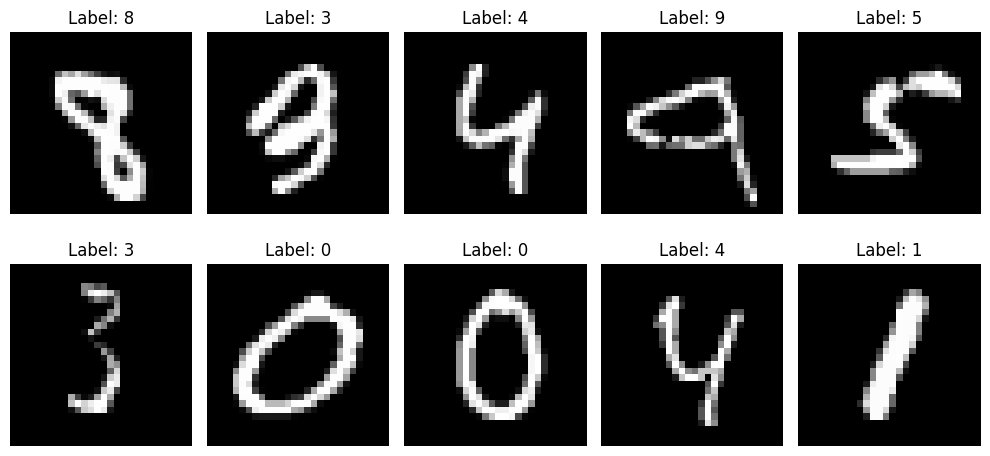

In [21]:
# Get a batch of training data
examples = iter(train_loader)
samples, labels = next(examples)  # Use next() to get the next batch

# Print the shape of the sample and labels
print(samples.shape, labels.shape)

# Create a 2x5 grid to display 10 images
plt.figure(figsize=(10, 5))  # Set the size of the figure

# Loop through the first 10 samples and plot them
for i in range(10):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns, index starts from 1
    plt.imshow(samples[i][0], cmap='gray')  # Show the first channel of the image (grayscale)
    plt.title(f"Label: {labels[i].item()}")  # Display the corresponding label
    plt.axis('off')  # Hide the axes for a cleaner look

# Show the plot
plt.tight_layout()
plt.show()

### Training
In the following cell we will import the Neural network module and initialize it

In [22]:
# class NeuralNetwork(nn.Module):
#     def __init__(self):

#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(28*28, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 32)
#         self.fc4 = nn.Linear(64, 10)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = x.view(-1, 28*28)  # Flatten the input
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


#### Bonus

In [23]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(64*7*7, 128)
#         self.fc2 = nn.Linear(128, 10)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.5)
#         self.pool = nn.MaxPool2d(2, 2)

#     def forward(self, x):
#         x = self.pool(self.relu(self.conv1(x)))
#         x = self.pool(self.relu(self.conv2(x)))
#         x = x.view(-1, 64*7*7)
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x


In [24]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        
        # Create layers dynamically
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        for layer in self.layers[:-1]:
            x = self.relu(layer(x))  # Apply ReLU to all but the last layer
        x = self.layers[-1](x)  # Last layer without ReLU
        return x

In [25]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    TrainLoss = []
    ValLoss = []
    TrainAcc = []
    ValAcc = []
    for epoch in range(epochs):
        train_loss = 0
        train_correct = 0
        total_train = 0
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_accuracy = 100 * train_correct / total_train
        TrainAcc.append(train_accuracy)

        val_loss = 0
        val_correct = 0
        total_val = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * val_correct / total_val
        ValAcc.append(val_accuracy)
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
        TrainLoss.append(train_loss/len(train_loader))
        ValLoss.append(val_loss/len(val_loader))
        
    return TrainLoss, ValLoss, TrainAcc, ValAcc

# Epochs = 10
# epochs = range(1, Epochs+1)
# train_losses, val_losses, train_accuracies, val_accuracies_lr = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=Epochs)


In [26]:
def plot(epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    # Create a single figure
    plt.figure(figsize=(10, 4))  

    # Plot Training and Validation Loss in the first subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()

    # Plot Training and Validation Accuracy in the second subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Epochs')
    plt.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the figure
    plt.show()


0.001
Epoch 1, Train Loss: 2.2214, Val Loss: 2.1131, Train Acc: 28.46%, Val Acc: 49.98%
Epoch 2, Train Loss: 1.9103, Val Loss: 1.6606, Train Acc: 60.25%, Val Acc: 65.49%
Epoch 3, Train Loss: 1.3664, Val Loss: 1.1167, Train Acc: 71.40%, Val Acc: 75.53%
Epoch 4, Train Loss: 0.9363, Val Loss: 0.8052, Train Acc: 78.71%, Val Acc: 80.97%
Epoch 5, Train Loss: 0.7124, Val Loss: 0.6466, Train Acc: 82.67%, Val Acc: 83.31%


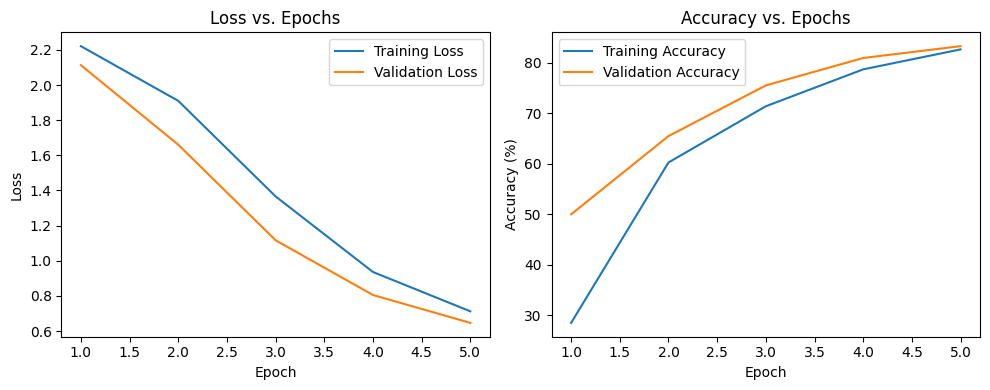

0.005
Epoch 1, Train Loss: 0.4949, Val Loss: 0.4186, Train Acc: 86.42%, Val Acc: 87.89%
Epoch 2, Train Loss: 0.3783, Val Loss: 0.3596, Train Acc: 89.25%, Val Acc: 89.60%
Epoch 3, Train Loss: 0.3361, Val Loss: 0.3173, Train Acc: 90.17%, Val Acc: 90.75%
Epoch 4, Train Loss: 0.3111, Val Loss: 0.3150, Train Acc: 90.85%, Val Acc: 90.78%
Epoch 5, Train Loss: 0.2913, Val Loss: 0.2814, Train Acc: 91.49%, Val Acc: 91.53%


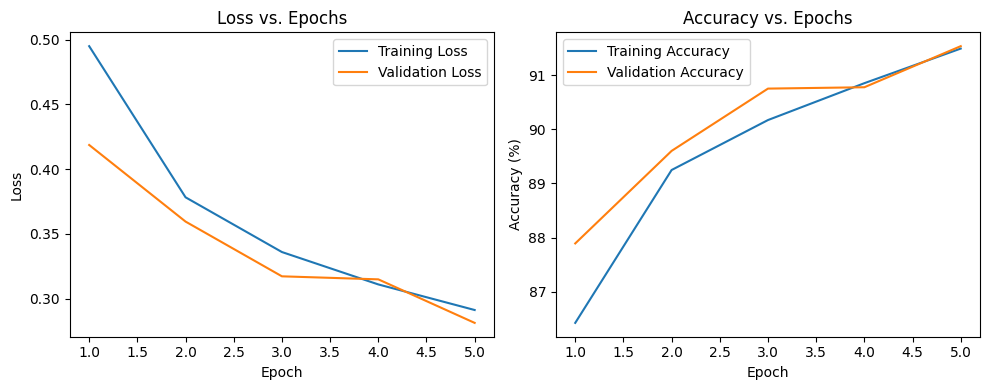

0.01
Epoch 1, Train Loss: 0.2788, Val Loss: 0.2605, Train Acc: 91.82%, Val Acc: 92.12%
Epoch 2, Train Loss: 0.2511, Val Loss: 0.2413, Train Acc: 92.51%, Val Acc: 92.97%
Epoch 3, Train Loss: 0.2281, Val Loss: 0.2335, Train Acc: 93.31%, Val Acc: 92.99%
Epoch 4, Train Loss: 0.2084, Val Loss: 0.2008, Train Acc: 93.91%, Val Acc: 93.97%
Epoch 5, Train Loss: 0.1889, Val Loss: 0.1992, Train Acc: 94.50%, Val Acc: 94.15%


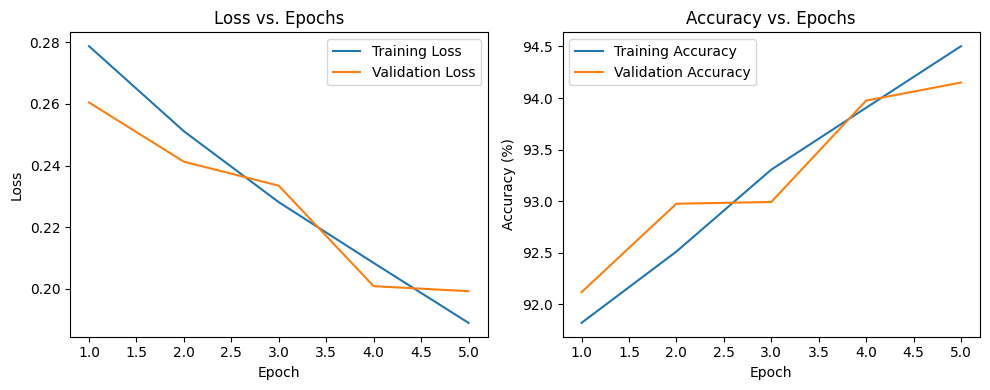

0.05
Epoch 1, Train Loss: 0.2384, Val Loss: 0.1691, Train Acc: 92.64%, Val Acc: 95.14%
Epoch 2, Train Loss: 0.1606, Val Loss: 0.1370, Train Acc: 95.04%, Val Acc: 95.80%
Epoch 3, Train Loss: 0.1306, Val Loss: 0.1267, Train Acc: 95.90%, Val Acc: 96.08%
Epoch 4, Train Loss: 0.1085, Val Loss: 0.1069, Train Acc: 96.65%, Val Acc: 96.97%
Epoch 5, Train Loss: 0.0938, Val Loss: 0.1271, Train Acc: 97.02%, Val Acc: 96.33%


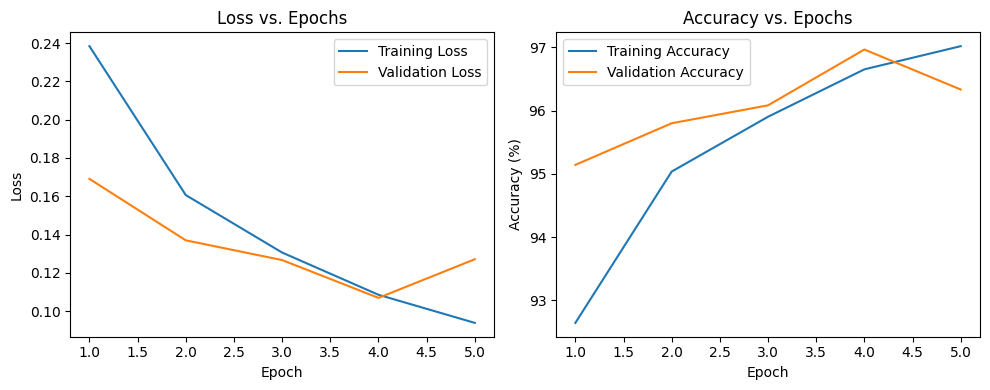


Best learning rate : 0.05 with Validation Accuracy: 96.97%



In [27]:
beginning_model = [784, 128, 64, 10]       # 2 hidden layers
model = NeuralNetwork(beginning_model)
criterion = nn.CrossEntropyLoss()
Epochs =5
max_accuracy = 0 
best_lr = 0 
learning_rate = [.001, .005, .01, .05] 
# epochs = list(range(1, Epochs + 1))
for i in range(0,4):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate[i])
    print(learning_rate[i])
    train_losses, val_losses, train_accuracies, val_accuracies_lr = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=Epochs)
    plot(list(range(1, Epochs + 1)),train_losses,val_losses,train_accuracies,val_accuracies_lr)
    if max(val_accuracies_lr) > max_accuracy:
        max_accuracy = max(val_accuracies_lr)
        best_lr = learning_rate[i]
optimizer = optim.SGD(model.parameters(), lr=best_lr)
print(f"\nBest learning rate : {best_lr} with Validation Accuracy: {max(val_accuracies_lr):.2f}%\n")

16
Epoch 1, Train Loss: 0.1536, Val Loss: 0.1227, Train Acc: 95.14%, Val Acc: 96.18%
Epoch 2, Train Loss: 0.1123, Val Loss: 0.0930, Train Acc: 96.52%, Val Acc: 96.99%
Epoch 3, Train Loss: 0.0904, Val Loss: 0.1010, Train Acc: 97.15%, Val Acc: 96.83%
Epoch 4, Train Loss: 0.0773, Val Loss: 0.1480, Train Acc: 97.47%, Val Acc: 95.82%
Epoch 5, Train Loss: 0.0679, Val Loss: 0.0967, Train Acc: 97.81%, Val Acc: 97.17%


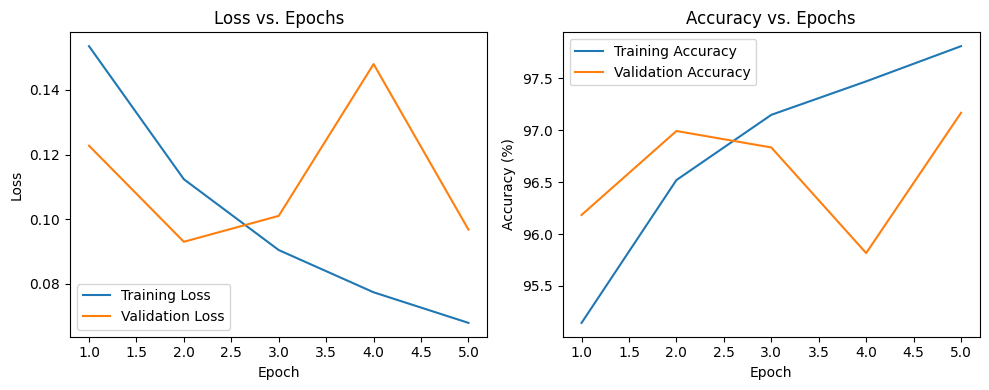

32
Epoch 1, Train Loss: 0.0541, Val Loss: 0.0600, Train Acc: 98.31%, Val Acc: 98.14%
Epoch 2, Train Loss: 0.0411, Val Loss: 0.0489, Train Acc: 98.67%, Val Acc: 98.57%
Epoch 3, Train Loss: 0.0364, Val Loss: 0.0577, Train Acc: 98.84%, Val Acc: 98.25%
Epoch 4, Train Loss: 0.0295, Val Loss: 0.0516, Train Acc: 99.06%, Val Acc: 98.49%
Epoch 5, Train Loss: 0.0250, Val Loss: 0.0493, Train Acc: 99.24%, Val Acc: 98.56%


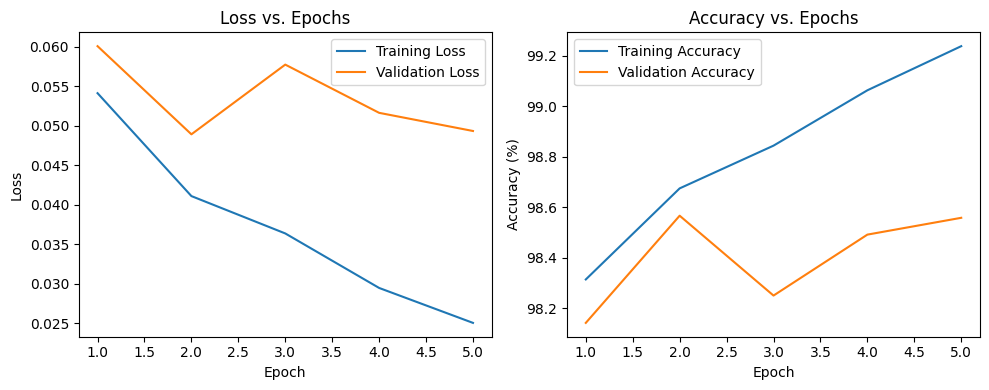

48
Epoch 1, Train Loss: 0.0309, Val Loss: 0.0322, Train Acc: 99.11%, Val Acc: 98.99%
Epoch 2, Train Loss: 0.0238, Val Loss: 0.0324, Train Acc: 99.34%, Val Acc: 98.98%
Epoch 3, Train Loss: 0.0210, Val Loss: 0.0299, Train Acc: 99.37%, Val Acc: 99.06%
Epoch 4, Train Loss: 0.0181, Val Loss: 0.0294, Train Acc: 99.48%, Val Acc: 99.14%
Epoch 5, Train Loss: 0.0146, Val Loss: 0.0305, Train Acc: 99.60%, Val Acc: 99.09%


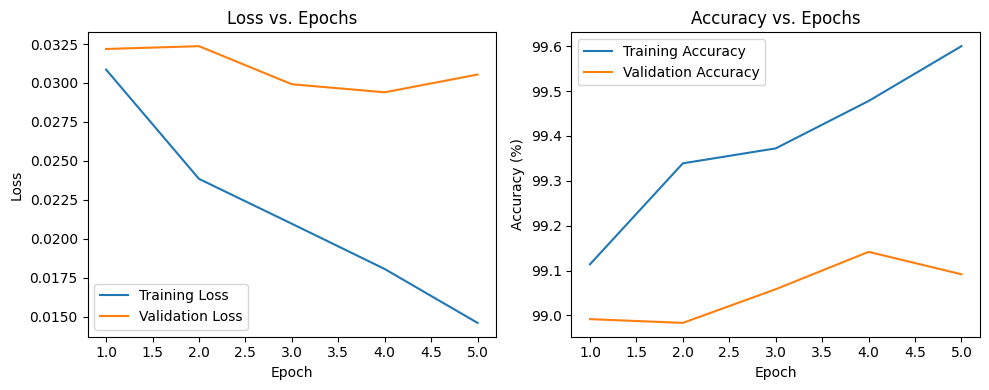

64
Epoch 1, Train Loss: 0.0223, Val Loss: 0.0215, Train Acc: 99.35%, Val Acc: 99.37%
Epoch 2, Train Loss: 0.0175, Val Loss: 0.0200, Train Acc: 99.54%, Val Acc: 99.42%
Epoch 3, Train Loss: 0.0143, Val Loss: 0.0200, Train Acc: 99.62%, Val Acc: 99.41%
Epoch 4, Train Loss: 0.0124, Val Loss: 0.0217, Train Acc: 99.70%, Val Acc: 99.41%
Epoch 5, Train Loss: 0.0112, Val Loss: 0.0205, Train Acc: 99.73%, Val Acc: 99.38%


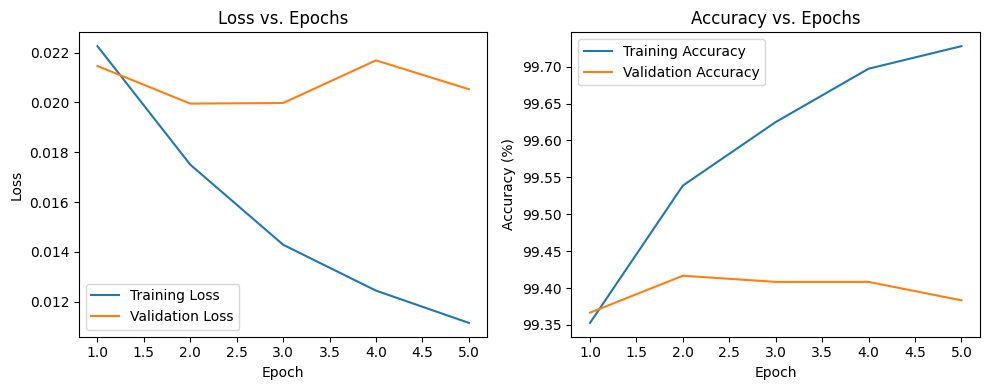


Best batch Size : 64 with Validation Accuracy: 99.42%



In [28]:
batchSize = [16 , 32 , 48, 64] 
max_accuracy = 0
val_accuracies_bitch = []

for i in range(0,4):
    train_size = int(0.6 * len(mnist_dataset))
    val_size = int(0.2 * len(mnist_dataset))
    test_size = len(mnist_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batchSize[i], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batchSize[i], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batchSize[i], shuffle=False)
    print(batchSize[i])
    train_losses, val_losses, train_accuracies, val_accuracies_bitch = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=Epochs)
    plot(list(range(1, Epochs + 1)),train_losses,val_losses,train_accuracies,val_accuracies_bitch)
    if max(val_accuracies_bitch) > max_accuracy:
        max_accuracy = max(val_accuracies_bitch)
        best_batch = batchSize[i]
    
batchSize = best_batch
train_size = int(0.6 * len(mnist_dataset))
val_size = int(0.2 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchSize, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)
print(f"\nBest batch Size : {best_batch} with Validation Accuracy: {max(val_accuracies_bitch):.2f}%\n")

Testing different layer configurations...

Training with layer configuration: [784, 128, 64, 10]
Epoch 1, Train Loss: 0.6656, Val Loss: 0.3437, Train Acc: 79.97%, Val Acc: 90.08%
Epoch 2, Train Loss: 0.3035, Val Loss: 0.3003, Train Acc: 90.87%, Val Acc: 90.48%
Epoch 3, Train Loss: 0.2326, Val Loss: 0.2071, Train Acc: 92.92%, Val Acc: 93.58%
Epoch 4, Train Loss: 0.1847, Val Loss: 0.1674, Train Acc: 94.39%, Val Acc: 95.00%
Epoch 5, Train Loss: 0.1528, Val Loss: 0.1883, Train Acc: 95.33%, Val Acc: 94.51%


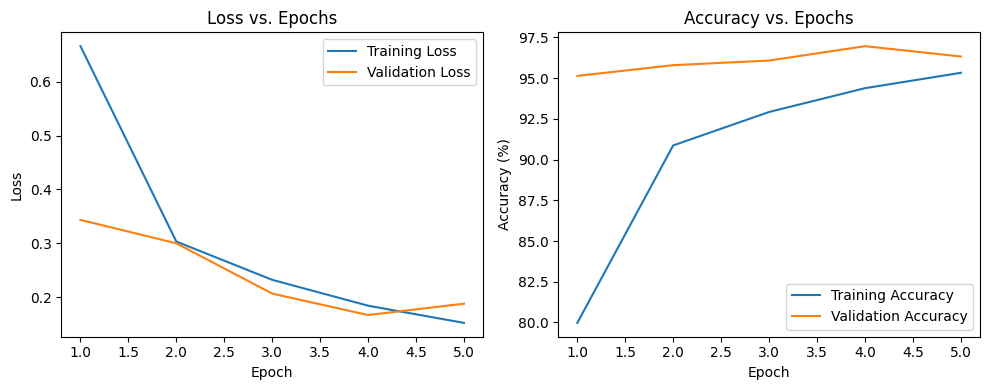

Training with layer configuration: [784, 128, 64, 32, 10]
Epoch 1, Train Loss: 0.9391, Val Loss: 0.5191, Train Acc: 68.50%, Val Acc: 81.49%
Epoch 2, Train Loss: 0.3258, Val Loss: 0.2629, Train Acc: 89.94%, Val Acc: 92.06%
Epoch 3, Train Loss: 0.2350, Val Loss: 0.2042, Train Acc: 92.76%, Val Acc: 93.93%
Epoch 4, Train Loss: 0.1744, Val Loss: 0.1505, Train Acc: 94.55%, Val Acc: 95.40%
Epoch 5, Train Loss: 0.1425, Val Loss: 0.1559, Train Acc: 95.65%, Val Acc: 95.28%


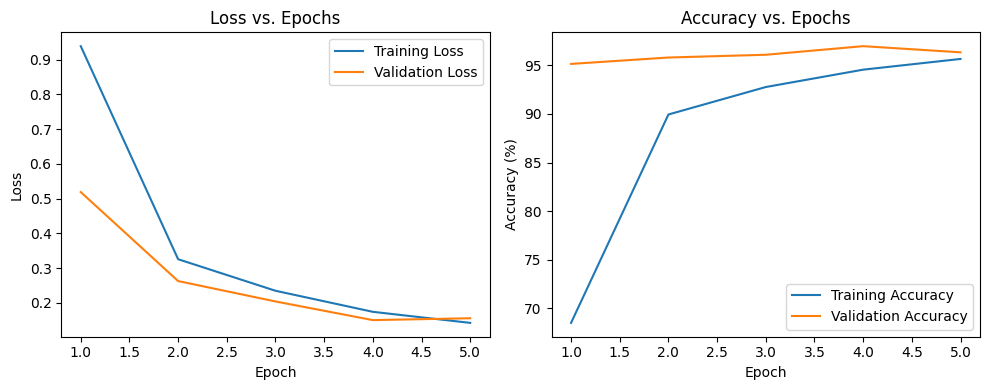

Training with layer configuration: [784, 256, 128, 64, 32, 10]
Epoch 1, Train Loss: 1.2559, Val Loss: 0.5440, Train Acc: 56.92%, Val Acc: 83.03%
Epoch 2, Train Loss: 0.3686, Val Loss: 0.4212, Train Acc: 88.64%, Val Acc: 85.67%
Epoch 3, Train Loss: 0.2388, Val Loss: 0.3242, Train Acc: 92.70%, Val Acc: 89.33%
Epoch 4, Train Loss: 0.1756, Val Loss: 0.2433, Train Acc: 94.72%, Val Acc: 92.11%
Epoch 5, Train Loss: 0.1384, Val Loss: 0.2155, Train Acc: 95.82%, Val Acc: 92.50%


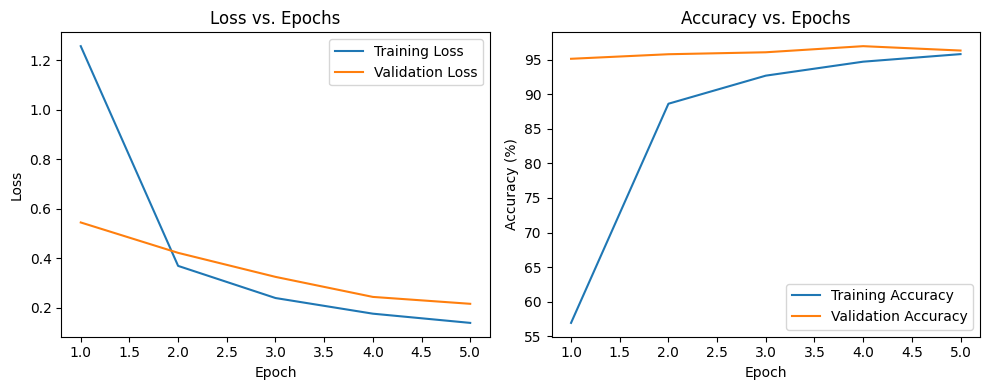

Training with layer configuration: [784, 512, 256, 128, 64, 32, 10]
Epoch 1, Train Loss: 1.9053, Val Loss: 0.7890, Train Acc: 30.48%, Val Acc: 72.39%
Epoch 2, Train Loss: 0.5151, Val Loss: 0.2855, Train Acc: 83.86%, Val Acc: 91.35%
Epoch 3, Train Loss: 0.2614, Val Loss: 0.2451, Train Acc: 92.01%, Val Acc: 92.36%
Epoch 4, Train Loss: 0.1867, Val Loss: 0.3849, Train Acc: 94.36%, Val Acc: 87.89%
Epoch 5, Train Loss: 0.1426, Val Loss: 0.1505, Train Acc: 95.73%, Val Acc: 95.33%


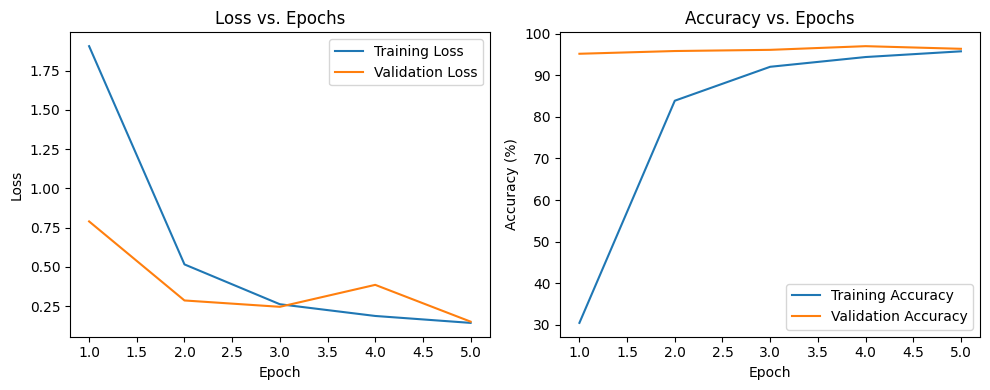


Best Layer Configuration: [784, 128, 64, 32, 10] with Validation Accuracy: 95.40%



In [29]:
# criterion = nn.CrossEntropyLoss()
layer_nums = [
    [784, 128, 64, 10],       # 2 layers
    [784, 128, 64, 32, 10],   # 3 layers
    [784, 256, 128, 64, 32, 10],   # 4 layers
    [784, 512, 256, 128, 64, 32, 10]   # 5 layers
]

# Epochs = 3
best_val_accuracy_layer = 0
best_layer_nums = None

print("Testing different layer configurations...\n")
for layer in layer_nums:
    print(f"Training with layer configuration: {layer}")
    model = NeuralNetwork(layer)

    optimizer = optim.SGD(model.parameters(), lr=best_lr)
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs = Epochs)
    plot(list(range(1, Epochs + 1)),train_losses,val_losses,train_accuracies,val_accuracies_lr)
    if max(val_accuracies) > best_val_accuracy_layer:
        best_val_accuracy_layer = max(val_accuracies)
        best_layer_nums = layer

print(f"\nBest Layer Configuration: {best_layer_nums} with Validation Accuracy: {best_val_accuracy_layer:.2f}%\n")



Testing random neuron configurations for the best number of hidden layers

Trial 1, Neuron Configuration: [784, 159, 142, 228, 10]
Epoch 1, Train Loss: 1.7653, Val Loss: 0.8153, Train Acc: 45.80%, Val Acc: 77.39%
Epoch 2, Train Loss: 0.5659, Val Loss: 0.4644, Train Acc: 83.50%, Val Acc: 85.82%
Epoch 3, Train Loss: 0.4052, Val Loss: 0.3854, Train Acc: 88.12%, Val Acc: 88.28%
Epoch 4, Train Loss: 0.3519, Val Loss: 0.3275, Train Acc: 89.77%, Val Acc: 90.14%
Epoch 5, Train Loss: 0.3195, Val Loss: 0.3055, Train Acc: 90.63%, Val Acc: 90.64%


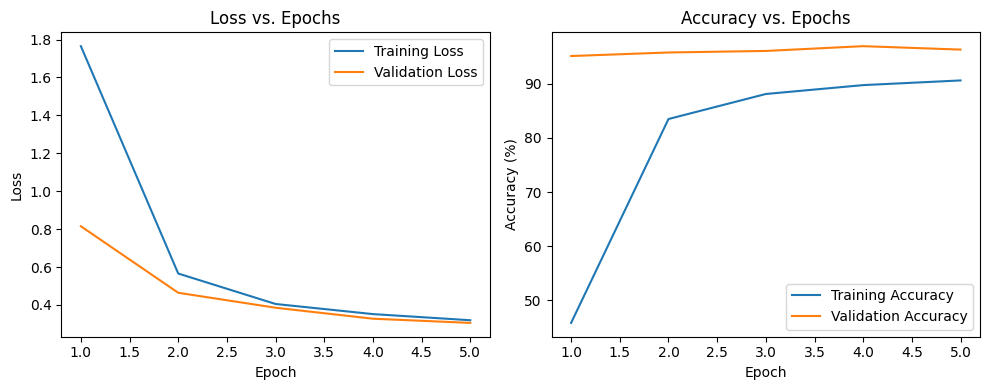

Validation Accuracy for Trial 1: 90.64%

Trial 2, Neuron Configuration: [784, 74, 239, 203, 10]
Epoch 1, Train Loss: 1.8551, Val Loss: 0.9789, Train Acc: 36.99%, Val Acc: 71.91%
Epoch 2, Train Loss: 0.6415, Val Loss: 0.4716, Train Acc: 81.23%, Val Acc: 86.42%
Epoch 3, Train Loss: 0.4172, Val Loss: 0.3817, Train Acc: 87.83%, Val Acc: 88.64%
Epoch 4, Train Loss: 0.3591, Val Loss: 0.3413, Train Acc: 89.32%, Val Acc: 89.79%
Epoch 5, Train Loss: 0.3254, Val Loss: 0.3040, Train Acc: 90.49%, Val Acc: 91.18%


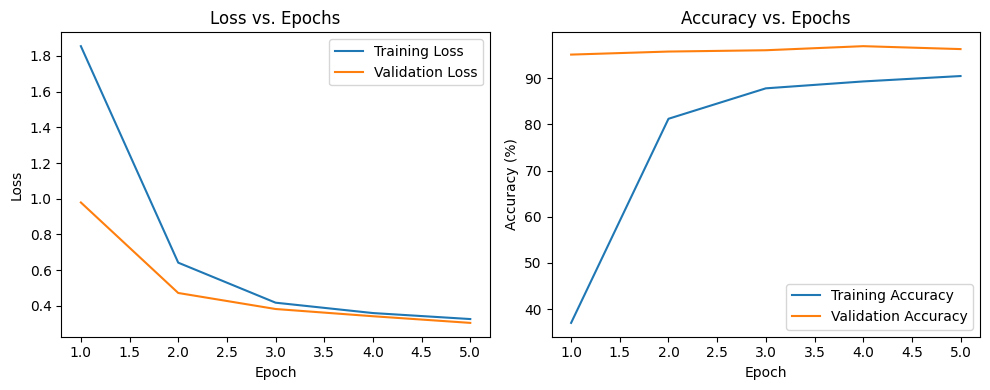

Validation Accuracy for Trial 2: 91.18%

Trial 3, Neuron Configuration: [784, 127, 178, 138, 10]
Epoch 1, Train Loss: 1.8918, Val Loss: 0.9689, Train Acc: 42.23%, Val Acc: 74.33%
Epoch 2, Train Loss: 0.6256, Val Loss: 0.4779, Train Acc: 82.22%, Val Acc: 85.38%
Epoch 3, Train Loss: 0.4207, Val Loss: 0.3769, Train Acc: 87.75%, Val Acc: 89.09%
Epoch 4, Train Loss: 0.3624, Val Loss: 0.3629, Train Acc: 89.48%, Val Acc: 89.03%
Epoch 5, Train Loss: 0.3272, Val Loss: 0.3203, Train Acc: 90.40%, Val Acc: 90.69%


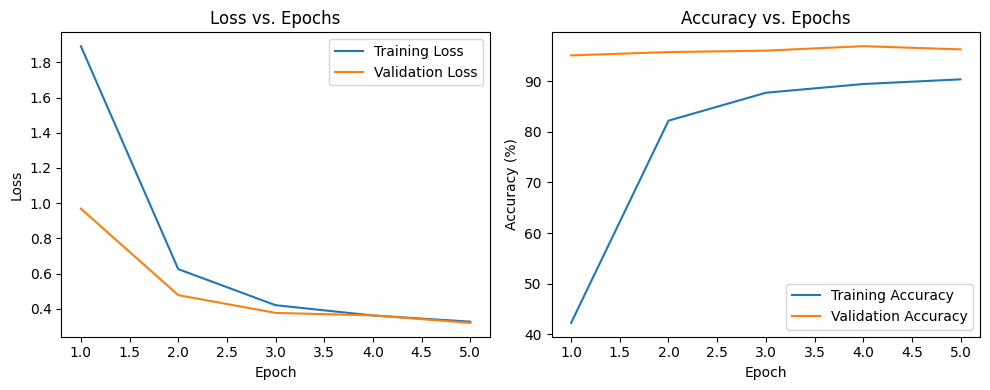

Validation Accuracy for Trial 3: 90.69%

Best Neuron Configuration: [784, 128, 64, 32, 10] with Validation Accuracy: 95.40%


In [30]:
best_num_hidden_layers = len(best_layer_nums) - 2  # Exclude input (784) and output (10) layers
best_neuron = best_layer_nums
best_neuron_accuracy = best_val_accuracy_layer  # Replace with best validation accuracy from Stage 1
print("\nTesting random neuron configurations for the best number of hidden layers\n")
for trial in range(3):  # Try 3 random configurations + best of layers
    hidden_layers = [random.randint(32, 256) for _ in range(best_num_hidden_layers)]  
    neuron_config = [784] + hidden_layers + [10]  
    print(f"Trial {trial + 1}, Neuron Configuration: {neuron_config}")
    model = NeuralNetwork(neuron_config)  
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs = Epochs)
    plot(list(range(1, Epochs + 1)),train_losses,val_losses,train_accuracies,val_accuracies_lr)
    if max(val_accuracies) > best_neuron_accuracy:
        best_neuron_accuracy = max(val_accuracies)
        best_neuron = neuron_config
    print(f"Validation Accuracy for Trial {trial + 1}: {max(val_accuracies):.2f}%\n")
print(f"Best Neuron Configuration: {best_neuron} with Validation Accuracy: {best_neuron_accuracy:.2f}%")


In the next cell we will define the loss function (cross-entropy), and optimizer (stochastic gradient descend).

In [31]:
# model = NeuralNetwork()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)

Here we will create a function to train the Network

### Analysis
in the following cells we will plot diagrams to analyse the model. The very next cell plots the training and validation loss.

In the next cell we will test the model on the test data and plot the acuuracy as epochs increase.

In [32]:
def test_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    test_correct = 0
    total_test = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            test_loss += loss.item()  # Accumulate loss
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class
            total_test += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * test_correct / total_test

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy
test_loss, test_accuracy = test_model(model, test_loader, criterion)


Test Loss: 0.3183, Test Accuracy: 90.81%


torch.Size([64, 1, 28, 28]) torch.Size([64])


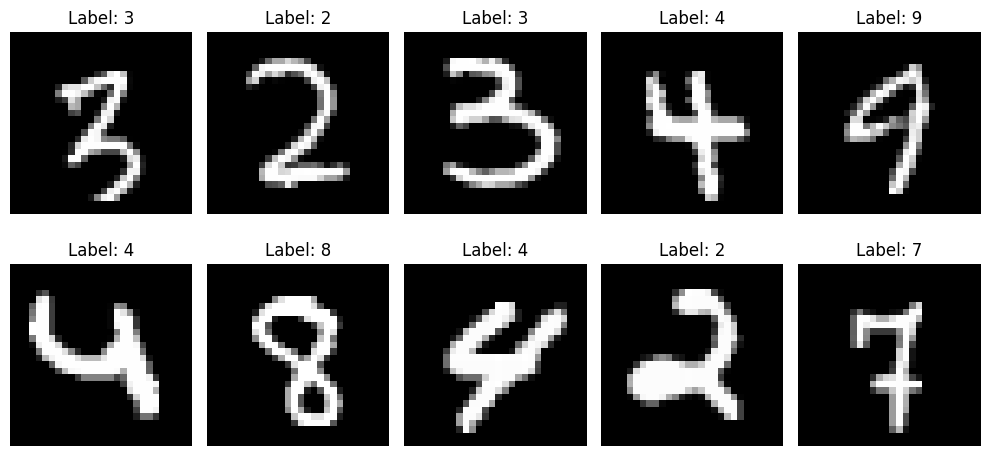

In [33]:
# test
# Get a batch of test data
examples = iter(test_loader)  # Replace train_loader with test_loader
samples, labels = next(examples)  # Use next() to get the next batch

# Print the shape of the sample and labels
print(samples.shape, labels.shape)

# Create a 2x5 grid to display 10 images
plt.figure(figsize=(10, 5))  # Set the size of the figure

# Loop through the first 10 samples and plot them
for i in range(10):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns, index starts from 1
    plt.imshow(samples[i+30][0], cmap='gray')  # Show the first channel of the image (grayscale)
    plt.title(f"Label: {labels[i+30].item()}")  # Display the corresponding label
    plt.axis('off')  # Hide the axes for a cleaner look

# Show the plot
plt.tight_layout()
plt.show()